
#### The data set includes information about:

   * Customers who left within the last month – the column is called Churn
   * Services that each customer has signed up for – phone, multiple lines, internet, online        * security, online backup, device protection, tech support, and streaming TV and movies
   * Customer account information – how long they’ve been a customer, contract, payment method, 
   * paperless billing, monthly charges, and total charges
   * Demographic info about customers – gender, age range, and if they have partners and dependents
   * Churn - dependent feature ('Yes' denotes customers left, 'No' denotes customer stay here)

In [32]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import SelectKBest
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick 

In [33]:
data = pd.read_csv('data.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [34]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

#### **将数据集分成数字项和文字项，文字项用LabelEncoder进行编码**

In [35]:
#总费用以对象据类型表示，将其转换为数值型
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

#### 对特征维度进行分类

In [36]:
# 数字项
numerical_feature = {feature for feature in data.columns if data[feature].dtypes != 'O'}
print(f'Count of Numerical feature: {len(numerical_feature)}')
print(f'Numerical feature are:\n {numerical_feature}')

Count of Numerical feature: 4
Numerical feature are:
 {'SeniorCitizen', 'TotalCharges', 'MonthlyCharges', 'tenure'}


In [37]:
# Categorical feature
categorical_feature = {feature for feature in data.columns if data[feature].dtypes == 'O'}
print(f'Count of Categorical feature: {len(categorical_feature)}')
print(f'Categorical feature are:\n {categorical_feature}')


Count of Categorical feature: 17
Categorical feature are:
 {'Churn', 'PhoneService', 'MultipleLines', 'InternetService', 'StreamingMovies', 'StreamingTV', 'DeviceProtection', 'PaperlessBilling', 'customerID', 'TechSupport', 'gender', 'OnlineBackup', 'OnlineSecurity', 'PaymentMethod', 'Contract', 'Dependents', 'Partner'}


#### 数据清洗

In [38]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [39]:
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [40]:
# 用平均值替换NaN值
data.TotalCharges = data.TotalCharges.fillna(data.TotalCharges.mean())

<AxesSubplot:>

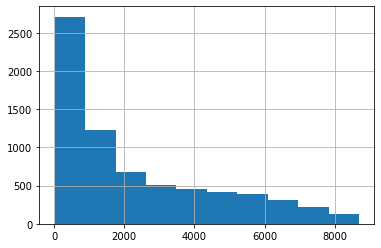

In [41]:
#绘制总费用直方图
data.TotalCharges.hist()

##### **执行特征编码技术将文字特征转换为数字特征**

In [42]:
print(categorical_feature)
print(data);

{'Churn', 'PhoneService', 'MultipleLines', 'InternetService', 'StreamingMovies', 'StreamingTV', 'DeviceProtection', 'PaperlessBilling', 'customerID', 'TechSupport', 'gender', 'OnlineBackup', 'OnlineSecurity', 'PaymentMethod', 'Contract', 'Dependents', 'Partner'}
      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male             

In [43]:
encoder = LabelEncoder()
for feature in categorical_feature:
    data[feature] = encoder.fit_transform(data[feature])
print(data);

      customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0           5375       0              0        1           0       1   
1           3962       1              0        0           0      34   
2           2564       1              0        0           0       2   
3           5535       1              0        0           0      45   
4           6511       0              0        0           0       2   
...          ...     ...            ...      ...         ...     ...   
7038        4853       1              0        1           1      24   
7039        1525       0              0        1           1      72   
7040        3367       0              0        1           1      11   
7041        5934       1              1        1           0       4   
7042        2226       1              0        0           0      66   

      PhoneService  MultipleLines  InternetService  OnlineSecurity  ...  \
0                0              1                0          

In [44]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5375,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,3962,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,2564,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,5535,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,6511,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


In [45]:
# 去掉无用的customerID项
data.drop(columns=['customerID'], inplace=True)
print(data);

      gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          0              0        1           0       1             0   
1          1              0        0           0      34             1   
2          1              0        0           0       2             1   
3          1              0        0           0      45             0   
4          0              0        0           0       2             1   
...      ...            ...      ...         ...     ...           ...   
7038       1              0        1           1      24             1   
7039       0              0        1           1      72             1   
7040       0              0        1           1      11             0   
7041       1              1        1           0       4             1   
7042       1              0        0           0      66             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0                 1                0     

#### 执行特征缩放

In [46]:
# 使用minmaxscaler方法将功能值缩小到0到1之间
scaler = MinMaxScaler()
for feature in numerical_feature:
    data[[feature]] = scaler.fit_transform(data[[feature]])
print(data);

      gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
0          0            0.0        1           0  0.013889             0   
1          1            0.0        0           0  0.472222             1   
2          1            0.0        0           0  0.027778             1   
3          1            0.0        0           0  0.625000             0   
4          0            0.0        0           0  0.027778             1   
...      ...            ...      ...         ...       ...           ...   
7038       1            0.0        1           1  0.333333             1   
7039       0            0.0        1           1  1.000000             1   
7040       0            0.0        1           1  0.152778             0   
7041       1            1.0        1           0  0.055556             1   
7042       1            0.0        0           0  0.916667             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0                

#### 将数据集拆分为训练集和测试集

In [47]:
X = data.drop(columns='Churn')
y = data['Churn']

In [48]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [49]:
# 这个数据集不平衡
y.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

#### **开始训练**

In [50]:
# 对数几率回归
Log_reg = LogisticRegression(C=150, max_iter=150)
Log_reg.fit(X_train, y_train)
log_pred = Log_reg.predict(X_test)

print(f'Accuracy score : {accuracy_score(log_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(log_pred, y_test)}')
print(f'Classification report :\n {classification_report(log_pred, y_test)}')

Accuracy score : 0.8019872249822569
Confusion matrix :
 [[928 176]
 [103 202]]
Classification report :
               precision    recall  f1-score   support

           0       0.90      0.84      0.87      1104
           1       0.53      0.66      0.59       305

    accuracy                           0.80      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.82      0.80      0.81      1409



In [51]:
# 随机森林分类器
Rfc = RandomForestClassifier(n_estimators=120,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=5)
Rfc.fit(X_train, y_train)
rfc_pred = Rfc.predict(X_test)

print(f'Accuracy score : {accuracy_score(rfc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_pred, y_test)}')
print(f'Classification report :\n {classification_report(rfc_pred, y_test)}')

Accuracy score : 0.794180269694819
Confusion matrix :
 [[942 201]
 [ 89 177]]
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.82      0.87      1143
           1       0.47      0.67      0.55       266

    accuracy                           0.79      1409
   macro avg       0.69      0.74      0.71      1409
weighted avg       0.83      0.79      0.81      1409



In [52]:
# 梯度提升决策树
Dtc = DecisionTreeClassifier(criterion='gini', splitter='random', min_samples_leaf=15)
Dtc.fit(X_train, y_train)
dtc_pred = Dtc.predict(X_test)

print(f'Accuracy score : {accuracy_score(dtc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_pred, y_test)}')
print(f'Classification report :\n {classification_report(dtc_pred, y_test)}')

Accuracy score : 0.7885024840312278
Confusion matrix :
 [[923 190]
 [108 188]]
Classification report :
               precision    recall  f1-score   support

           0       0.90      0.83      0.86      1113
           1       0.50      0.64      0.56       296

    accuracy                           0.79      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.81      0.79      0.80      1409



In [53]:
# 找到最适合knn的k值
BK_value = []
for x in range(1, 100):
    Knn = KNeighborsClassifier(n_neighbors=x, p=2)
    Knn.fit(X_train, y_train)
    knn_pred = Knn.predict(X_test)
    BK_value.append(np.mean(knn_pred != y_test))

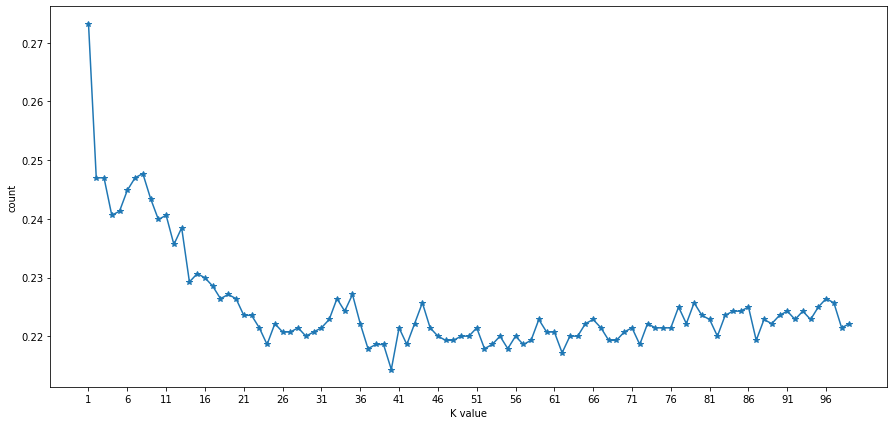

In [54]:
# 输出折线图
plt.figure(figsize=(15,7))
plt.xlabel('K value')
plt.ylabel('count')
plt.plot(range(1,100), BK_value, marker='*')
plt.xticks(range(1,100)[::5])
plt.show()

**从图中可以看出最适合的k应为64左右**

In [55]:
Knn = KNeighborsClassifier(n_neighbors=64, p=2)
Knn.fit(X_train, y_train)
knn_pred = Knn.predict(X_test)

In [56]:
print(f'Accuracy score : {accuracy_score(knn_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(knn_pred, y_test)}')
print(f'Classification report :\n {classification_report(knn_pred, y_test)}')

Accuracy score : 0.7799858055358411
Confusion matrix :
 [[900 179]
 [131 199]]
Classification report :
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      1079
           1       0.53      0.60      0.56       330

    accuracy                           0.78      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.79      0.78      0.78      1409



**利用SMOTE算法纠正不平衡数据集**

In [57]:
st=SMOTEENN()
X_train_st,y_train_st = st.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_st)))

The number of classes before fit Counter({0: 4143, 1: 1491})
The number of classes after fit Counter({1: 2756, 0: 2163})


In [58]:
# 将训练集和测试集分开
X_train_sap, X_test_sap, y_train_sap, y_test_sap = train_test_split(X_train_st, y_train_st, test_size=0.2)

In [59]:
# 决策树分类器
Dtc_sampling = DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=7, min_samples_leaf=15)
Dtc_sampling.fit(X_train_sap, y_train_sap)
dtc_sampling_pred = Dtc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(dtc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(dtc_sampling_pred, y_test_sap)}')

Accuracy score : 0.9105691056910569
Confusion matrix :
 [[370  45]
 [ 43 526]]
Classification report :
               precision    recall  f1-score   support

           0       0.90      0.89      0.89       415
           1       0.92      0.92      0.92       569

    accuracy                           0.91       984
   macro avg       0.91      0.91      0.91       984
weighted avg       0.91      0.91      0.91       984



In [60]:
#随机森林分类器
Rfc_sampling = RandomForestClassifier(n_estimators=150,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=6)
Rfc_sampling.fit(X_train_sap, y_train_sap)
rfc_sampling_pred = Rfc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(rfc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(rfc_sampling_pred, y_test_sap)}')

Accuracy score : 0.9298780487804879
Confusion matrix :
 [[375  31]
 [ 38 540]]
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       406
           1       0.95      0.93      0.94       578

    accuracy                           0.93       984
   macro avg       0.93      0.93      0.93       984
weighted avg       0.93      0.93      0.93       984



In [61]:
Log_reg_sampling = LogisticRegression(C=10, max_iter=150)
Log_reg_sampling.fit(X_train_sap, y_train_sap)
Log_sampling_pred = Log_reg_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(Log_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(Log_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(Log_sampling_pred, y_test_sap)}')

Accuracy score : 0.9227642276422764
Confusion matrix :
 [[377  40]
 [ 36 531]]
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.90      0.91       417
           1       0.93      0.94      0.93       567

    accuracy                           0.92       984
   macro avg       0.92      0.92      0.92       984
weighted avg       0.92      0.92      0.92       984



In [62]:
# KNN 
Knn_sampling = KNeighborsClassifier(n_neighbors=3, p=2)  # 使用欧几里得距离
Knn_sampling.fit(X_train_sap, y_train_sap)
knn_sampling_pred = Knn_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(knn_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(knn_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(knn_sampling_pred, y_test_sap)}')

Accuracy score : 0.9664634146341463
Confusion matrix :
 [[385   5]
 [ 28 566]]
Classification report :
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       390
           1       0.99      0.95      0.97       594

    accuracy                           0.97       984
   macro avg       0.96      0.97      0.97       984
weighted avg       0.97      0.97      0.97       984

